In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ResourceWarning)
warnings.filterwarnings('ignore', category = BytesWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36447 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


In [4]:
db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_stress_SH.db'
session_SH = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_stress_except_NANP.db'
session_NANP = cc.database.create_session(db)

db = '/scratch/x77/db6174/access-om2/archive/databases/1deg_jra55_ryf/cc_database_stress_eq_except_NANP.db'
session_eq = cc.database.create_session(db)

expt = ['1deg_jra55_ryf_param_KPP', '1deg_jra55_ryf_stress_SH', '1deg_jra55_ryf_stress_except_NANP', '1deg_jra55_ryf_stress_eq_except_NANP']
session = [session_SH, session_SH, session_NANP, session_eq]
name = ['Control', 'Stress_SH', 'Nostress_0to50N', 'Nostress_10to50N']

In [5]:
start_time = '1900-01-01'
end_time = '1999-12-31'

ncoarse = 12

x_min = [-100, -250, -70, -250]
x_max = [ 10 , -100,  20, -80 ]
y_min = [ 20 ,  20 , -80, -80 ]
y_max = [ 75 ,  75 , -55, -55 ]
basin = ['NA', 'NP', 'SA', 'SP']

Text(0.5, 1.0, 'Latitudinal distribution of the wind stress mask')

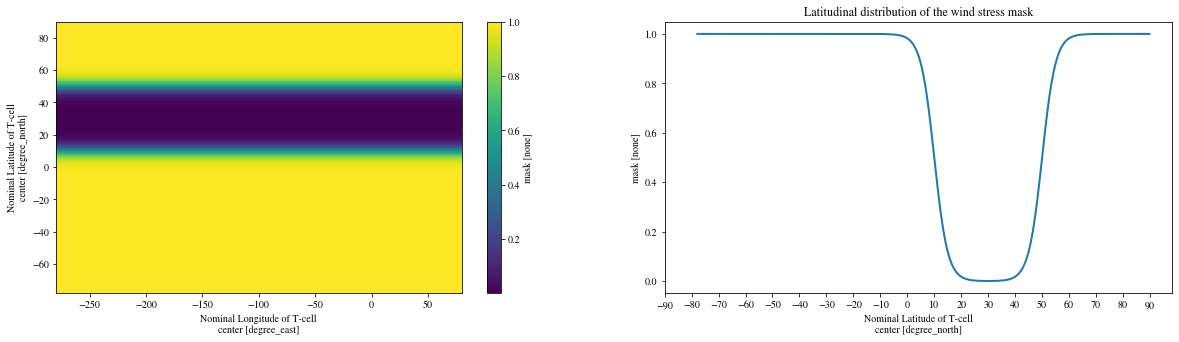

In [6]:
from netCDF4 import Dataset

nc_file = '/scratch/x77/db6174/1deg_inputs/stress_eq_except_NANP/wind_mask.nc'
nc_dataset = Dataset(nc_file, mode = 'r')
mask_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
mask = mask_dataset.mask

fig, axes = plt.subplots(ncols = 2, figsize = (20, 5))

mask.plot(ax = axes[0])
plt.title('Spatial distribution of the wind stress mask')

mask.sel(xu_ocean = -200, method = 'nearest').plot(ax = axes[1])
plt.xticks(np.linspace(-90, 90, 19))
plt.title('Latitudinal distribution of the wind stress mask')

## KPP Depth

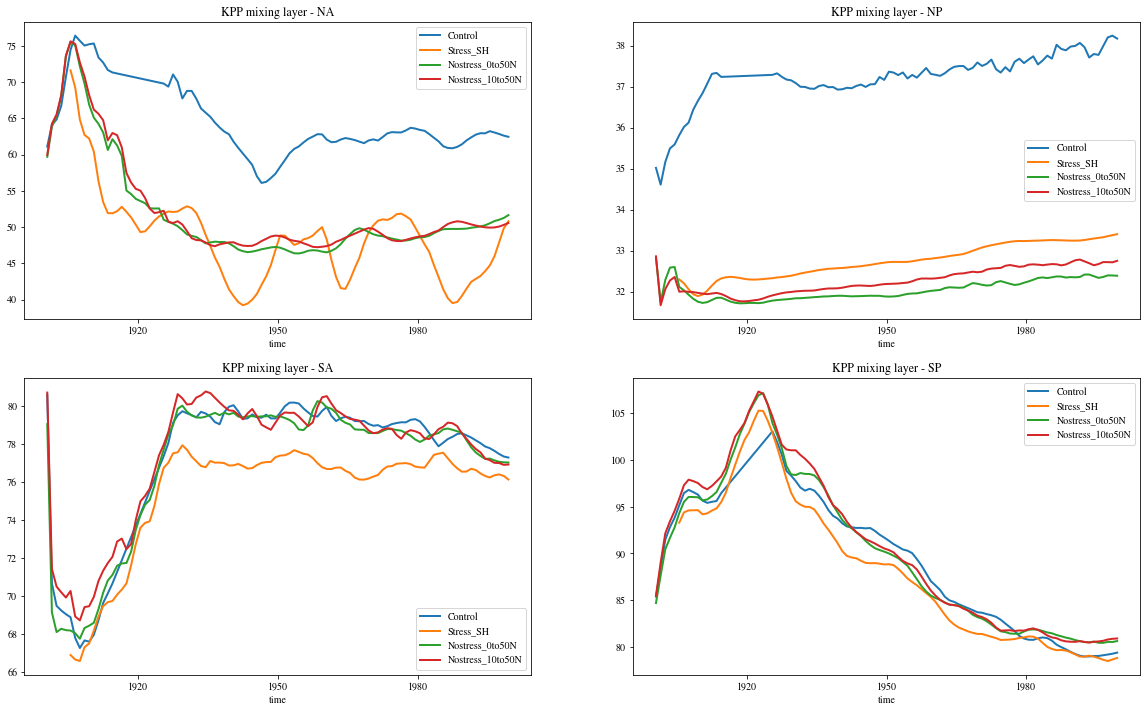

In [7]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    
    hblt = cc.querying.getvar(expt = expt[i], session = j, variable = 'hblt', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    finite_variable = xr.ufuncs.isfinite(hblt)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        hblt_basin = (hblt*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        hblt_basin = hblt_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        hblt_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('KPP mixing layer - ' + basin[k])

## Surface temperature

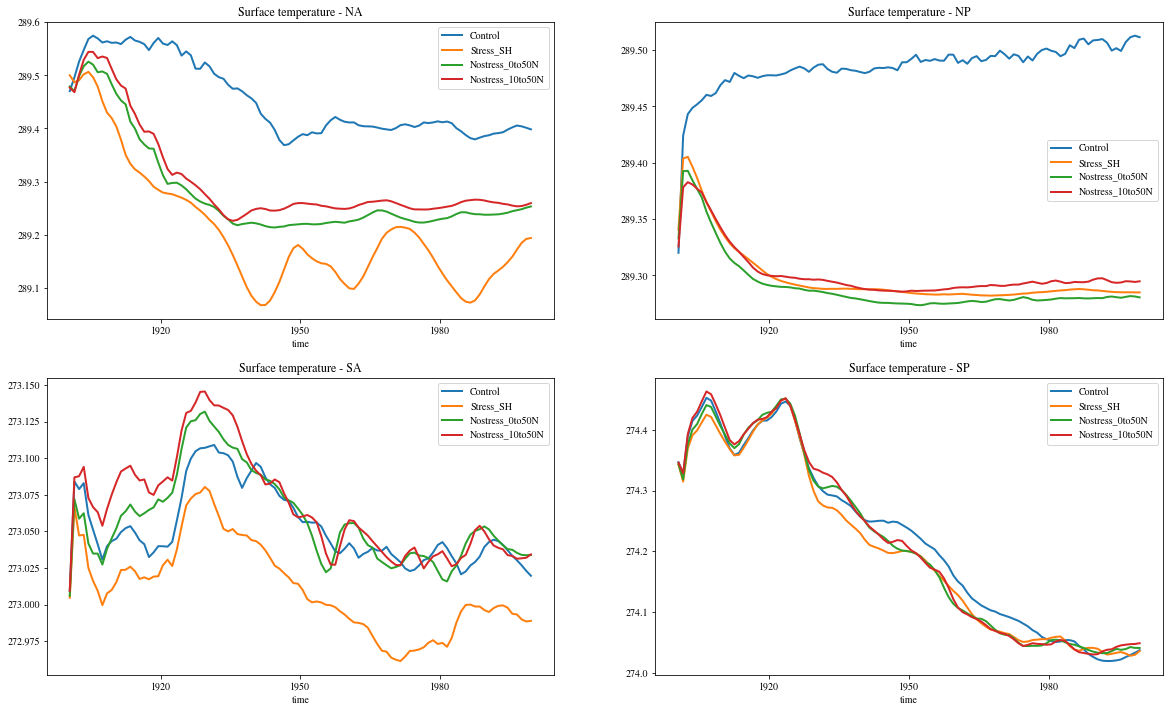

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    
    temp_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'temp', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    temp_sfc = temp_sfc.isel(st_ocean = 1)
    finite_variable = xr.ufuncs.isfinite(temp_sfc)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        temp_sfc_basin = (temp_sfc*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        temp_sfc_basin = temp_sfc_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        temp_sfc_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('Surface temperature - ' + basin[k])

## Surface salinity

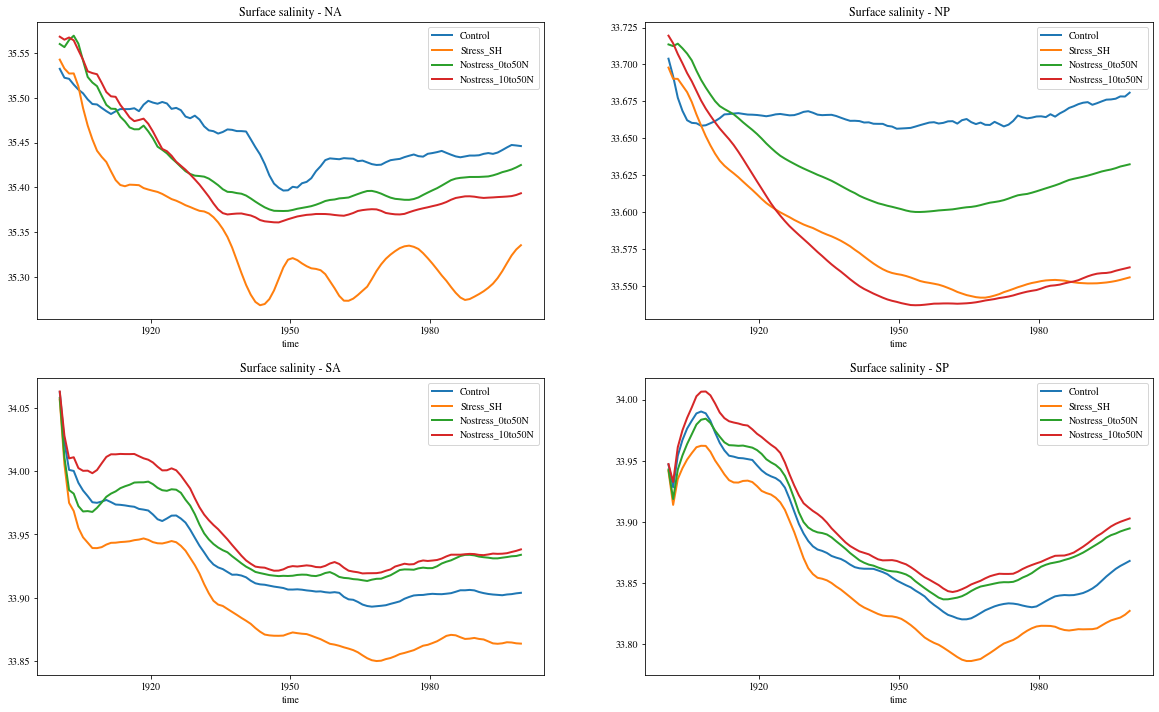

In [9]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    
    salt_sfc = cc.querying.getvar(expt = expt[i], session = j, variable = 'salt', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    salt_sfc = salt_sfc.isel(st_ocean = 1)
    finite_variable = xr.ufuncs.isfinite(salt_sfc)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        salt_sfc_basin = (salt_sfc*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        salt_sfc_basin = salt_sfc_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        salt_sfc_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('Surface salinity - ' + basin[k])

## Surface heat flux

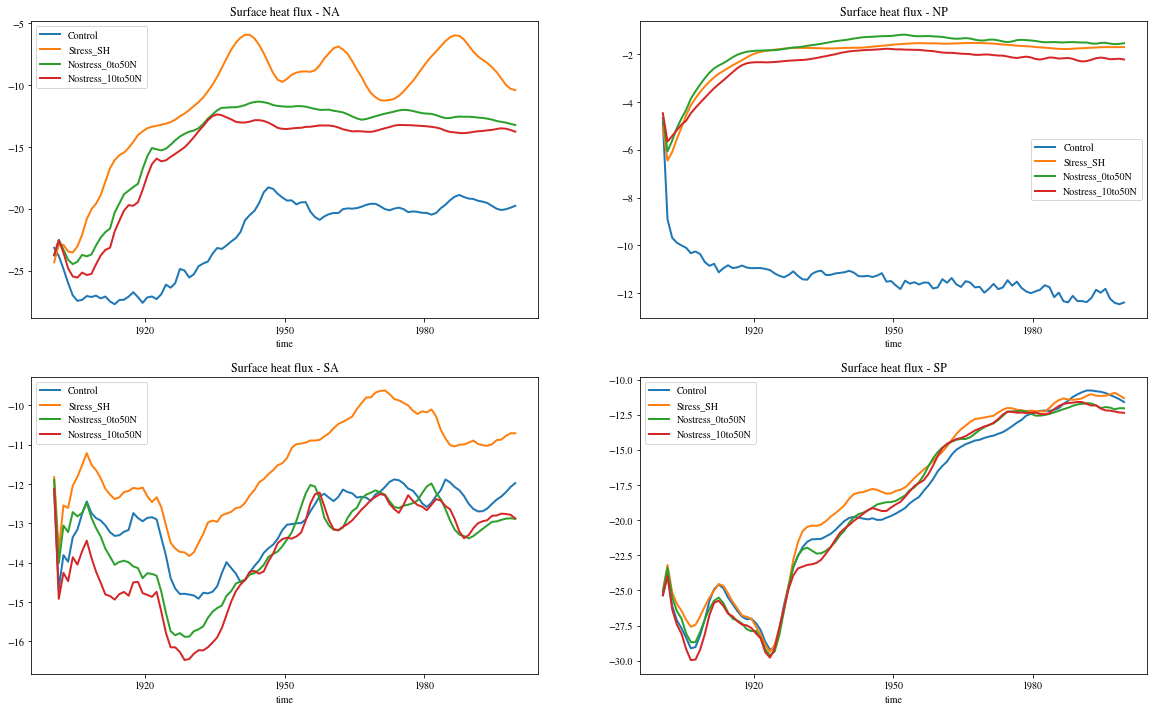

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for i, j in enumerate(session):
    
    hflux = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly').sel(time = slice(start_time, end_time))
    finite_variable = xr.ufuncs.isfinite(hflux)
    
    for k, l in enumerate(basin):
        
        area_t = cc.querying.getvar(expt = expt[i], variable = 'area_t', session = j, frequency = 'static', n = 1)
        area_t = area_t.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
        area_t_basin = (finite_variable * area_t).mean('time')
        
        hflux_basin = (hflux*area_t_basin).sum(dim = ['yt_ocean','xt_ocean'])/area_t_basin.sum(dim = ['yt_ocean','xt_ocean'])
        hflux_basin = hflux_basin.coarsen({"time": ncoarse}, boundary = "trim").mean()
        hflux_basin.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)],label = name[i])
        del area_t
        
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title('Surface heat flux - ' + basin[k])

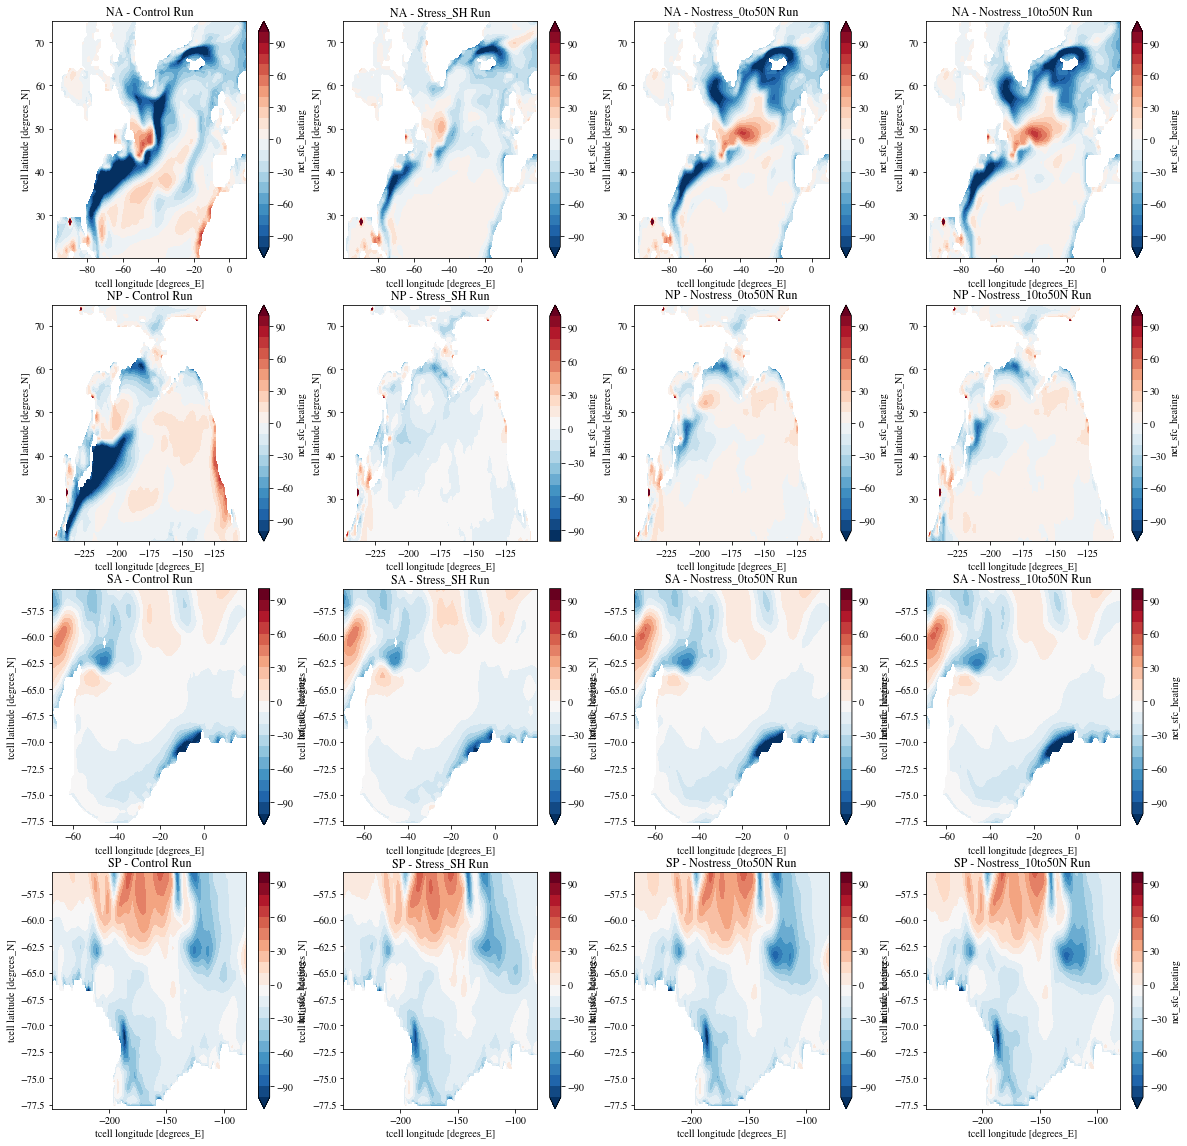

In [12]:
start_time_heat = '1990-01-01'
end_time_heat = '1999-12-31'

fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))

for i, j in enumerate(session):
    sfc_heat = cc.querying.getvar(expt = expt[i], session = j, variable = 'net_sfc_heating', frequency = '1 monthly').sel(time = slice(start_time, end_time))
        
    for k, l in enumerate(basin):
        sfc_heat_basin = sfc_heat.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))    
        sfc_heat_basin.sel(time = slice(start_time_heat, end_time_heat)).mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-100, 100, 21))
        axes[k][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

## Heat flux : Individual contributions

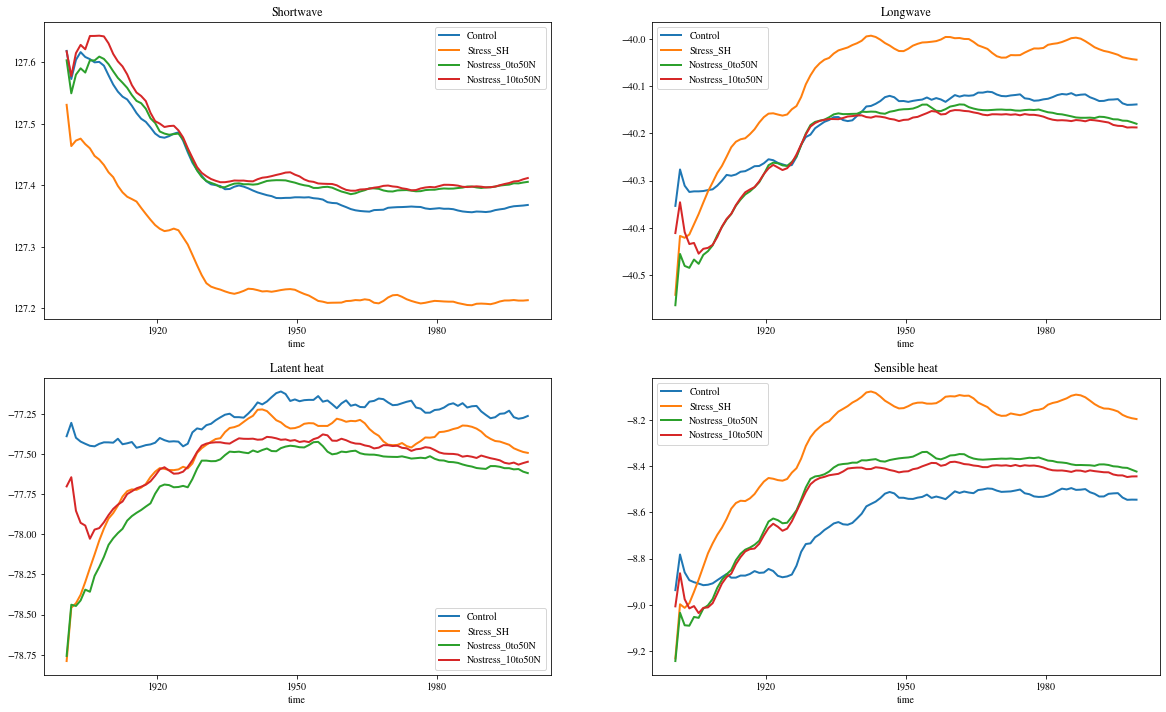

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

var_list = ['swflx', 'lw_heat', 'evap_heat', 'sens_heat']
var_name = ['Shortwave', 'Longwave', 'Latent heat', 'Sensible heat']

area_t = cc.querying.getvar(expt = expt[0], variable = 'area_t', session = session[0], frequency = 'static', n = 1)

for k, l in enumerate(var_list):
    for i, j in enumerate(session):
        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly').sel(time = slice(start_time, end_time))
        variable = (variable * area_t).sum(dim = ['yt_ocean','xt_ocean'])/area_t.sum(dim = ['yt_ocean','xt_ocean'])
        variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        variable.sel(time = slice(start_time, end_time)).plot(ax = axes[int(k/2)][int(k%2)], label = name[i])
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title(var_name[k])

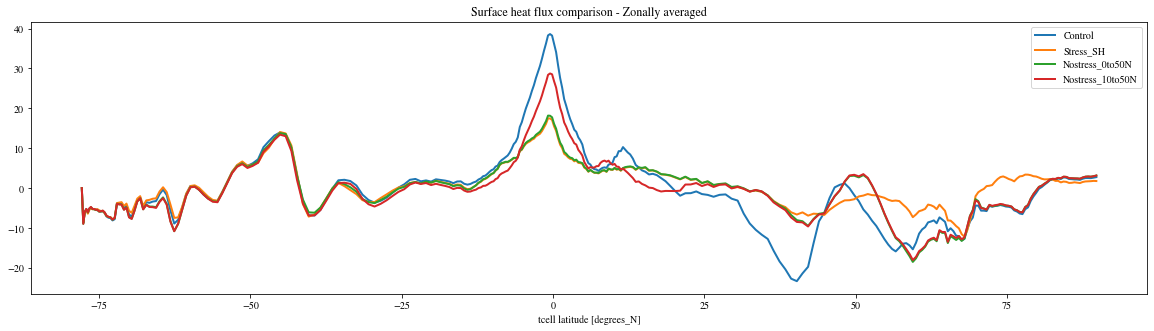

In [14]:
plt.figure(figsize = (20, 5))

start_time_heat = '1990-01-01'
end_time_heat = end_time

for i, j in enumerate(session):
    sum_var = 0
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly').sel(time = slice(start_time_heat, end_time_heat))
        variable = (variable * area_t).sum(dim = ['xt_ocean'])/area_t.sum(dim = ['xt_ocean'])
        variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        sum_var = sum_var + variable
    sum_var.sel(time = slice(start_time_heat, end_time_heat)).mean('time').plot(label = name[i])
    plt.legend()
    plt.title('Surface heat flux comparison - Zonally averaged')

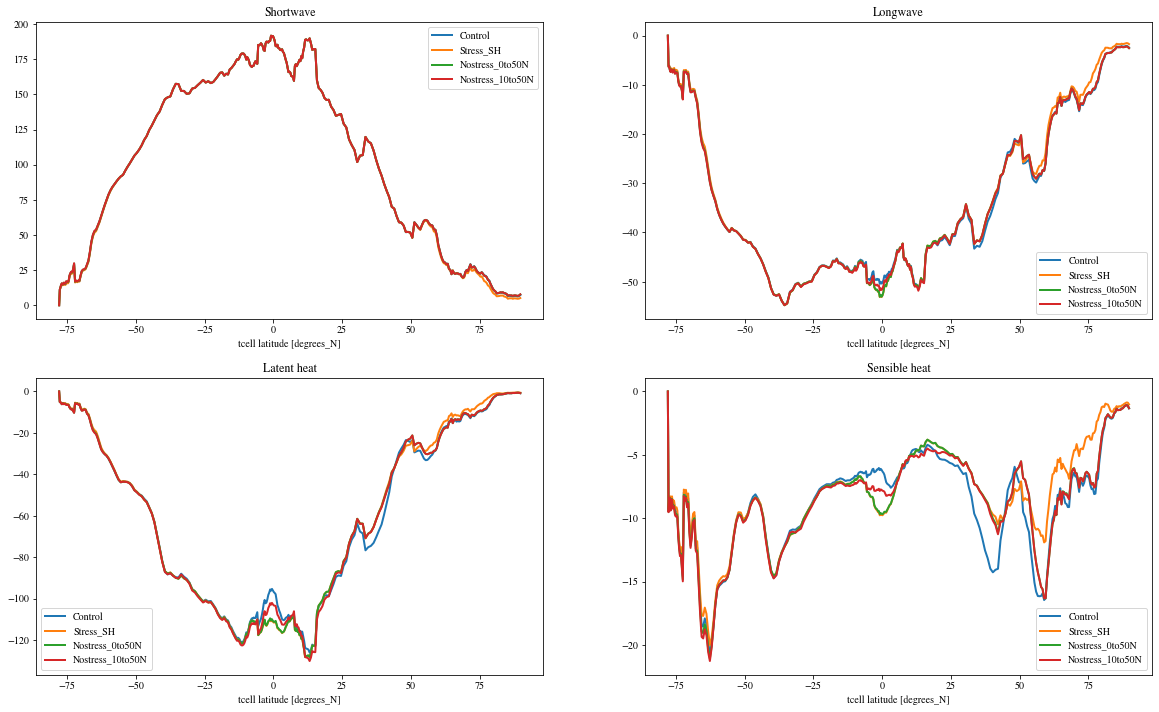

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 12))

for k, l in enumerate(var_list):
    for i, j in enumerate(session):
        variable = cc.querying.getvar(expt = expt[i], session = j, variable = l, frequency = '1 monthly').sel(time = slice(start_time, end_time))
        variable = (variable * area_t).sum(dim = ['xt_ocean'])/area_t.sum(dim = ['xt_ocean'])
        variable = variable.coarsen({"time": ncoarse}, boundary = "trim").mean()
        variable.sel(time = slice(start_time, end_time)).mean('time').plot(ax = axes[int(k/2)][int(k%2)], label = name[i])
        axes[int(k/2)][int(k%2)].legend()
        axes[int(k/2)][int(k%2)].set_title(var_name[k])

## Gyres

In [16]:
rho0 = 1025
start_time_gyre = '1980-01-01'
end_time_gyre = '1999-12-31'

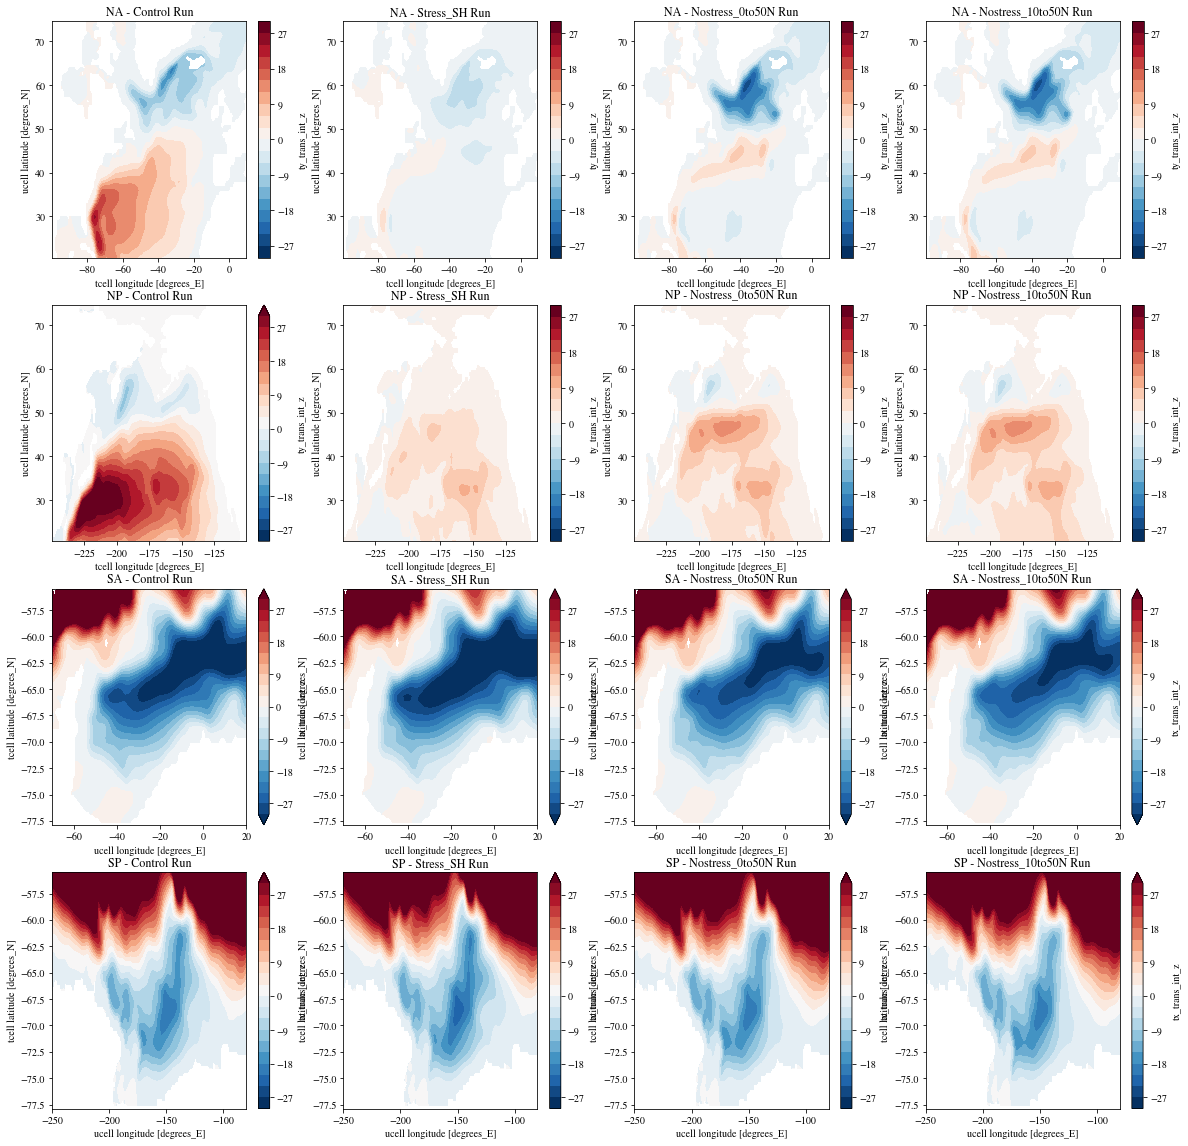

In [17]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20))

for i, j in enumerate(session):
    tx_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'tx_trans_int_z', frequency = '1 monthly').sel(time = slice(start_time_gyre, end_time_gyre))
    ty_trans = cc.querying.getvar(expt = expt[i], session = j, variable = 'ty_trans_int_z', frequency = '1 monthly').sel(time = slice(start_time_gyre, end_time_gyre))
    
    for k, l in enumerate(basin):
        if(l == 'NA' or l == 'NP'):
            ty_basin = ty_trans.sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
            psi_basin = ty_basin.cumsum('xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
        else:
            tx_basin = tx_trans.sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
            psi_basin = tx_basin.cumsum('yt_ocean').where(abs(tx_basin<=1.e20))/(rho0*1.e6)
            
        psi_basin.sel(time = slice(start_time, end_time)).mean('time').plot.contourf(ax = axes[k][i], levels = np.linspace(-30, 30, 21))
        axes[k][i].set_title(str(basin[k]) + ' - ' + name[i] + ' Run')

## Overturning circulation

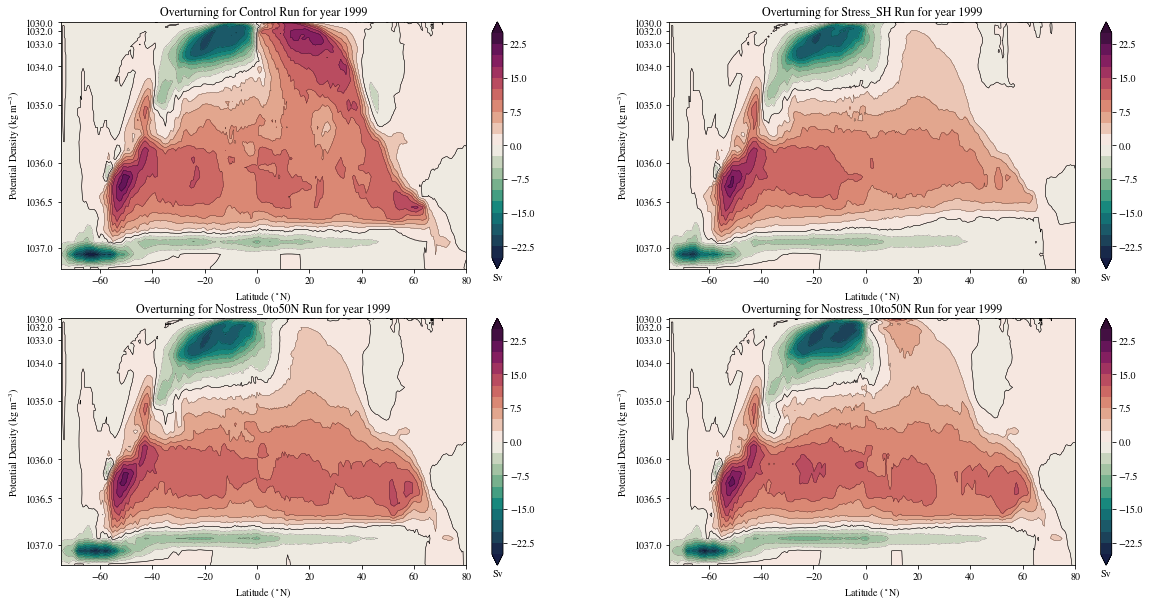

In [18]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10)) 
#clev = np.arange(-25, 27, 2)
clev = np.linspace(-25, 25, 21)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set teh stretching
start_time_OC = '1999-01-01'
end_time_OC = '1999-12-31'
rho = 1025 # mean density of sea-water in kg/m^3

for i, j in enumerate(session):
    
    psiGM = cc.querying.getvar(expt[i], 'ty_trans_rho_gm', session = j, start_time = start_time_OC, end_time = end_time_OC)
    psiGM = psiGM.sum('grid_xt_ocean')
    psiGM = psiGM / (1e6*rho)
    
    psi = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = start_time_OC, end_time = end_time_OC)
    psi = psi.sum('grid_xt_ocean').sel(time = slice(start_time_OC, end_time_OC))
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi_avg = psi.cumsum('potrho').mean('time') #- psi.sum('potrho').mean('time')
    
    psi_avg = psi_avg + psiGM.mean('time')

    p1 = ax[int(i/2)][int(i%2)].contourf(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, cmap=cm.cm.curl, levels = clev, extend = 'both')
    cb = plt.colorbar(p1, orientation = 'vertical', ax = ax[int(i/2)][int(i%2)])
    cb.ax.set_xlabel('Sv')
    ax[int(i/2)][int(i%2)].contour(psi_avg.grid_yu_ocean,(psi_avg.potrho - 1028)**scfac, psi_avg, levels = clev, colors = 'k', linewidths = 0.25)
    ax[int(i/2)][int(i%2)].contour(psi_avg.grid_yu_ocean,(psi_avg.potrho - 1028)**scfac, psi_avg, levels = [0.0,], colors = 'k', linewidths = 0.5)

    ax[int(i/2)][int(i%2)].set_yticks((yticks-1028)**scfac)
    ax[int(i/2)][int(i%2)].set_yticklabels(yticks)
    ax[int(i/2)][int(i%2)].set_ylim([0.5**scfac, 9.2**scfac])
    ax[int(i/2)][int(i%2)].invert_yaxis()
    ax[int(i/2)][int(i%2)].set_ylabel('Potential Density (kg m$^{-3}$)')
    ax[int(i/2)][int(i%2)].set_xlabel('Latitude ($^\circ$N)')
    ax[int(i/2)][int(i%2)].set_xlim([-75,80])
    ax[int(i/2)][int(i%2)].set_title('Overturning for ' + str(name[i]) + ' Run for year 1999');

### Sector overturning

In [19]:
def compute_basin_psi_rho(expt,session, basin_mask, nbound=None, start_time = start_time_OC, end_time = end_time_OC):
    rho = 1025 # mean density of sea-water in kg/m^3
    
    varlist = cc.querying.get_variables(session, expt)
    if varlist['name'].str.contains('ty_trans_rho_gm').any():
        GM = True
        print('GM is True')
        psiGM = cc.querying.getvar(expt,'ty_trans_rho_gm',session, n=nbound,start_time = start_time_OC, end_time = end_time)
        psiGM = psiGM.sum('grid_xt_ocean')
        psiGM = psiGM / (1e6*rho)
    else:
        GM = False
        print('GM is False')
        
    psi = cc.querying.getvar(expt, 'ty_trans_rho',session, n=nbound,start_time = start_time, end_time = end_time)      
    psi = psi / (1e6*rho) # converts kg/s to Sv
    psi = (psi * basin_mask).sum('grid_xt_ocean').cumsum('potrho').mean(dim = 'time').load() 
    if GM:
        psi = psi + psiGM.mean('time')
        
    return psi

GM is True
GM is True
GM is True
GM is True
GM is True
GM is True
GM is True
GM is True


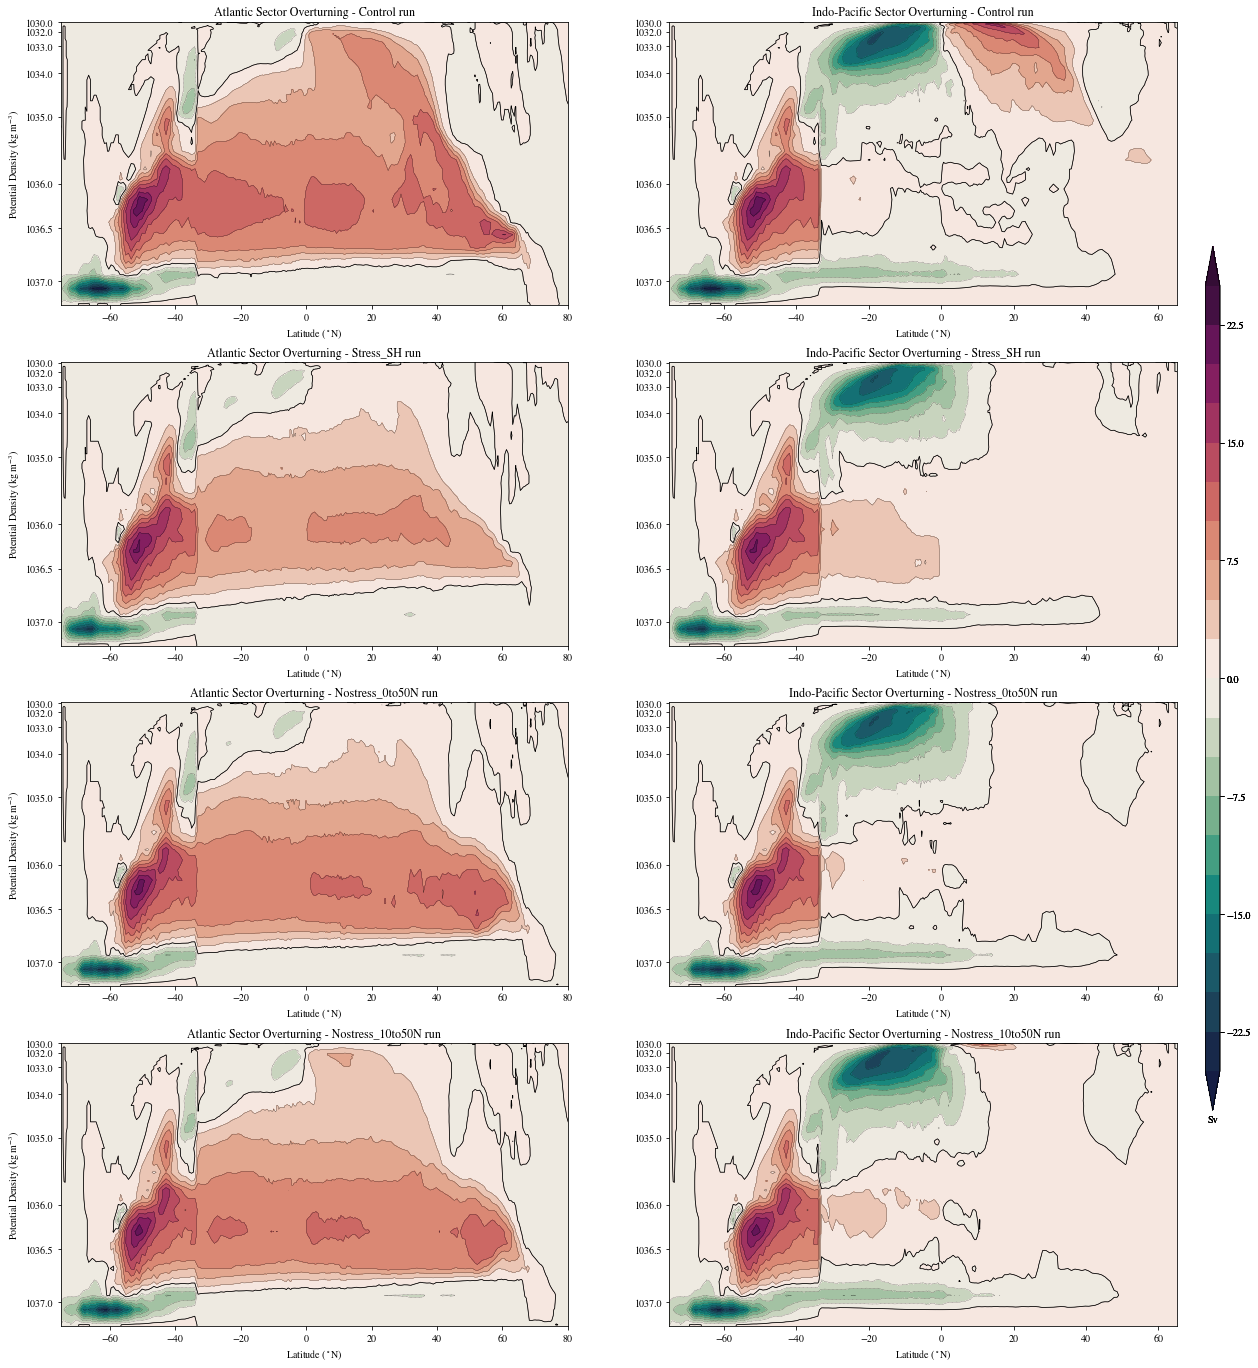

In [21]:
#clev=np.arange(-25,25,2)
clev = np.linspace(-25, 25, 21)
yticks = np.array([1030, 1032, 1033, 1034, 1035, 1036,1036.5, 1037])
scfac = 4  ## A power to set the stretching of the y-axis

fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20, 24))

for i, j in enumerate(session):
    psi = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = start_time_OC, end_time = end_time_OC)
    ht = cc.querying.getvar(expt[i], 'ht', session = j, n = -1)
    land_mask = ~ht.isnull()

    south_map = (land_mask.where(land_mask.yt_ocean < -34)).fillna(0) 
    indo_map1 = (land_mask.where(land_mask.yt_ocean < 9).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-65)).fillna(0) 
    indo_map2 = (land_mask.where(land_mask.yt_ocean < 15).where(land_mask.yt_ocean > 9).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-83.7)).fillna(0) 
    indo_map3 = (land_mask.where(land_mask.yt_ocean < 17).where(land_mask.yt_ocean > 15).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-93.3)).fillna(0) 
    indo_map4 = (land_mask.where(land_mask.yt_ocean < 85).where(land_mask.yt_ocean > 17).where(land_mask.xt_ocean >-280).where(land_mask.xt_ocean<-99)).fillna(0) 
    indo_map5 = (land_mask.where(land_mask.yt_ocean < 30.5).where(land_mask.yt_ocean > -34).where(land_mask.xt_ocean >25).where(land_mask.xt_ocean<80)).fillna(0) 
    
    indo_sector_map = indo_map1 + indo_map2 + indo_map3 + indo_map4 + indo_map5 + south_map
    indo_sector_mask = indo_sector_map.where(indo_sector_map>0)
    
    atlantic_sector_map = (indo_sector_mask * 0).fillna(1) * land_mask
    atlantic_sector_map = atlantic_sector_map + south_map
    atlantic_sector_mask = atlantic_sector_map.where(atlantic_sector_map>0)
    
    indo_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    indo_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    indo_sector_mask = indo_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})
    
    atlantic_sector_mask.coords['xt_ocean'] = psi.grid_xt_ocean.values
    atlantic_sector_mask.coords['yt_ocean'] = psi.grid_yu_ocean.values
    atlantic_sector_mask = atlantic_sector_mask.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yu_ocean'})

    atlantic_psi = compute_basin_psi_rho(expt[i], j, atlantic_sector_mask, start_time = start_time_OC, end_time = end_time)
    indopacific_psi = compute_basin_psi_rho(expt[i], j, indo_sector_mask, start_time = start_time_OC, end_time = end_time)
    
    p1 = axes[i][0].contourf(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, cmap=cm.cm.curl, levels=clev, extend='both')
    axes[i][0].contour(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, levels=clev, colors='k', linewidths=0.25)
    axes[i][0].contour(atlantic_psi.grid_yu_ocean,(atlantic_psi.potrho-1028)**scfac, atlantic_psi, levels=[0.0,], colors='k', linewidths=0.75)
    axes[i][0].set_yticks((yticks-1028)**scfac)
    axes[i][0].set_yticklabels(yticks)
    axes[i][0].set_ylim([0.5**scfac, 9.2**scfac])
    axes[i][0].invert_yaxis()
    axes[i][0].set_ylabel('Potential Density (kg m$^{-3}$)')
    axes[i][0].set_xlabel('Latitude ($^\circ$N)')
    axes[i][0].set_xlim([-75,80])
    axes[i][0].set_title('Atlantic Sector Overturning - ' + name[i] + ' run');

    ## Plotting Indo-Pacific Sector
    p1 = axes[i][1].contourf(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, cmap=cm.cm.curl, levels=clev, extend='both')
    axes[i][1].contour(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, levels=clev, colors='k', linewidths=0.25)
    axes[i][1].contour(indopacific_psi.grid_yu_ocean,(indopacific_psi.potrho-1028)**scfac, indopacific_psi, levels=[0.0,], colors='k', linewidths=0.75)
    axes[i][1].set_yticks((yticks-1028)**scfac)
    axes[i][1].set_yticklabels(yticks)
    axes[i][1].set_ylim([0.5**scfac, 9.2**scfac])
    axes[i][1].invert_yaxis()
    axes[i][1].set_xlabel('Latitude ($^\circ$N)')
    axes[i][1].set_xlim([-75,65])
    axes[i][1].set_title('Indo-Pacific Sector Overturning - ' + name[i] + ' run');

    # Plot a colorbar
    cax = plt.axes([0.92, 0.25, 0.01, 0.5])
    cb = plt.colorbar(p1, cax = cax,orientation = 'vertical', ax = axes[i])
    cb.ax.set_xlabel('Sv')

## Global diagnostics

In [ ]:
ncoarse = 12

fig, axes = plt.subplots(nrows = 4, figsize = (20, 20))

var_list = ['temp_global_ave',    'salt_global_ave', 'temp_surface_ave',    'salt_surface_ave']
var_name = ['Global temperature', 'Global salinity', 'Surface temperature', 'Surface salinity']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l).sel(time = slice('1900-01-01', end_time))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

In [ ]:
fig, axes = plt.subplots(nrows = 2, figsize = (20, 12))

var_list = ['ke_tot',         'pe_tot'          ]
var_name = ['Kinetic energy', 'Potential energy']
for i, j in enumerate(expt):
    for k, l in enumerate(var_list):
        variable = cc.querying.getvar(expt = expt[i], session = session[i], variable = l).sel(time = slice('1900-01-01', end_time))
        variable = variable.coarsen({"time": ncoarse*30}, boundary = "trim").mean()
        variable.plot(ax = axes[k], label = name[i])
        axes[k].legend()
        axes[k].set_title(var_name[k])

## Circulation metrics

### ACC Transport

In [ ]:
xmin = -69.9
ymin = -71.6
ymax = -51.0
rho0 = 1036

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    DP_trans = cc.querying.getvar(expt[i], 'tx_trans_int_z', session = j, start_time = '1900-01-01', end_time = end_time).sel(
        xu_ocean = xmin, method='nearest').sel(yt_ocean = slice(ymin, ymax)).sum('yt_ocean')/rho0/1e6
    DP_trans = DP_trans.coarsen({"time": ncoarse}, boundary = "trim").mean()
    DP_trans.plot(label = name[i])
    plt.legend()

plt.title('Drake Passage Transport')

### AABW Circulation

In [ ]:
latitude = -45

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_aabw = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = '1900-01-01', end_time = end_time).sum(
        'grid_xt_ocean').sel(method = 'nearest', grid_yu_ocean = latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho = slice(1036.2, None)).min('potrho').resample(time = 'Y').mean()
    psi_aabw_sum.plot(label = name[i])
    plt.legend()

plt.title('AABW Circulation')

### AMOC Cell

In [ ]:
plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    psi_amoc = cc.querying.getvar(expt[i], 'ty_trans_rho', session = j, start_time = '1900-01-01', end_time = end_time).sel(
        grid_xt_ocean = slice(-103, -5)).sum('grid_xt_ocean').sel(method = 'Nearest', grid_yu_ocean = 26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho = slice(1035.5, None)).max('potrho').resample(time = 'Y').mean()
    psi_amoc_sum.plot(label = name[i])
    plt.legend()

plt.title('AMOC cell')

### Gulf stream transport

In [ ]:
xmin = -85
xmax = -75
ymin = 30
rho = 1030

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    GS = cc.querying.getvar(expt[i], 'ty_trans_int_z', session = j, start_time = '1900-01-01', end_time = end_time).sel(
        xt_ocean = slice(xmin, xmax)).sel(yu_ocean = ymin, method = 'nearest').sum('xt_ocean')/rho0/1e6
    GS = GS.coarsen({"time": ncoarse}, boundary = "trim").mean()
    GS.plot(label = name[i])
    plt.legend()

plt.title('Gulf stream WBC')

### Kuroshio current

In [ ]:
xmin = -250
xmax = -210
ymin = 30
rho = 1030

plt.figure(figsize = (20,5))

for i, j in enumerate(session):
    KC = cc.querying.getvar(expt[i], 'ty_trans_int_z', session = j, start_time = '1900-01-01', end_time = end_time).sel(
        xt_ocean = slice(xmin, xmax)).sel(yu_ocean = ymin, method = 'nearest').sum('xt_ocean')/rho0/1e6
    KC = KC.coarsen({"time": ncoarse}, boundary = "trim").mean()
    KC.plot(label = name[i])
    plt.legend()
    
plt.title('Kuroshio current WBC')